<h2> Load Modules </h2>

In [1]:
from time import time
import numpy, os
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import cv2

<h2> Collect Data </h2>

In [2]:
path="training/"

<h2> Prepare Data </h2>

In [3]:
data_slice = [70,195,78,172] # [ ymin, ymax, xmin, xmax]
# to extract the ‘interesting’ part of the image files 
# and avoid use statistical correlation from the background 

# resize ratio to reduce sample dimention
resize_ratio = 2.5

h = int((data_slice[1] - data_slice[0])/resize_ratio) #ymax - ymin slice, Height of image in float
w = int((data_slice[3] - data_slice[2])/resize_ratio) #xmax - xmin slice, Width of image in float 
print("Image dimension after resize (h,w) :", h, w)

n_sample = 0 #Initial sample count
label_count = 0 #Initial label count
n_classes = 0 #Initial class count

#PCA Component 
n_components = 7

Image dimension after resize (h,w) : 50 37


In [4]:
#Flat image Feature Vector
X=[]
#Int array of Label Vector
Y=[]

target_names = [] #Array to store the names of the persons

for directory in os.listdir(path):
    for file in os.listdir(path+directory):
        img=cv2.imread(path+directory+"/"+file)[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
        img=cv2.resize(img, (w,h))
        img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        featurevector=numpy.array(img).flatten()
        X.append(featurevector)
        Y.append(label_count)
        n_sample = n_sample + 1
    target_names.append(directory)
    label_count=label_count+1


print("Samples :", n_sample)
print("Class :", target_names)
n_classes = len(target_names)

Samples : 100
Class : ['Manar', 'Nawres']


<h2> Split Data </h2>

<h5><font color=pink>Next, we will use the train_test_split module from sklearn.model_selection and split the data (X-features and y-labels)into training data and testing data, with 25% of the data used for testing and the remaining 75% to train the model, so that we can train our model on training dataset and test its accuracy on unseen (test) data. </font></h5>

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42)

<h2>Feature Selection: PCA</h2>

<h5><font color=pink>using a dimensionality reduction technique. Dimensionality reduction is a type of unsupervised learning where we want to take higher-dimensional data, like images, and represent them in a lower-dimensional space.</font> </h5>

<h5><font color=pink>The essence of eigenfaces is an unsupervised dimensionality reduction algorithm called Principal Components Analysis (PCA) that we use to reduce the dimensionality of images into something smalle. We compute the covariance matrix of our data and consider that covariance matrix’s largest eigenvectors. Those are our principal axes and the axes that we project our data onto to reduce dimensions. Using this approach, we can take high-dimensional data and reduce it down to a lower dimension by selecting the largest eigenvectors of the covariance matrix and projecting onto those eigenvectors.</font></h5>

In [6]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, len(X_train)))
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("\n")
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 7 eigenfaces from 75 faces
done in 1.217s


Projecting the input data on the eigenfaces orthonormal basis
done in 0.024s


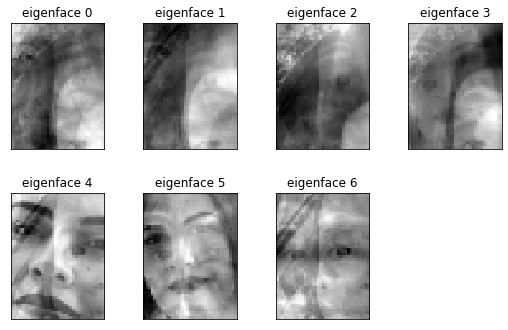

In [7]:
import matplotlib.pyplot as plt
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_components):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

<h2>Train Model</h2>

<h5><font color=pink>Once we’re done with dimensionality reduction, we will now move towards classification. First, we will train the SVM Classification model. We will use GridSearchCV, a library function that is an approach to hyperparameter tuning. It will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid, and return the best estimator in clf.best_estimator. Here we will adjust C (which controls the margin hardness) and gamma (which controls the size of the radial basis function kernel). </font></h5>

In [9]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, verbose=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print(clf.best_estimator_)

Fitting the classifier to the training set
Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\GLOBALINFO\Anaconda3\envs\ML\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] .............. C=1000.0, gamma=0.0001, score=0.654, total=   0.1s
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] .............. C=1000.0, gamma=0.0001, score=0.640, total=   0.0s
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] .............. C=1000.0, gamma=0.0001, score=0.750, total=   0.0s
[CV] C=1000.0, gamma=0.0005 ..........................................
[CV] .............. C=1000.0, gamma=0.0005, score=0.654, total=   0.0s
[CV] C=1000.0, gamma=0.0005 ..........................................
[CV] .............. C=1000.0, gamma=0.0005, score=0.640, total=   0.0s
[CV] C=1000.0, gamma=0.0005 ..........................................
[CV] .............. C=1000.0, gamma=0.0005, score=0.667, total=   0.0s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............... C=1000.0, gamma=0.001, score=0.654, total=   0.0s
[CV] C

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.2s finished
c:\Users\GLOBALINFO\Anaconda3\envs\ML\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<h4> Quantitative evaluation of the model quality on the test set </h4>

In [10]:
print("\n")
print("Predicting students's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print(clf.score(X_test_pca,y_test))
print("done in %0.3fs" % (time() - t0))



Predicting students's names on the test set
0.8
done in 0.119s


<h2>Evaluation</h2>

<h5><font color=pink>let us print the classification report  which will display the precision, recall, F1-score, and support scores for the model. This gives a deeper intuition of the classifier’s behavior.</font></h5>

In [11]:
print("\nClassification Report : ")
print(classification_report(y_test, y_pred, target_names=target_names))


Classification Report : 
              precision    recall  f1-score   support

       Manar       0.87      0.81      0.84        16
      Nawres       0.70      0.78      0.74         9

    accuracy                           0.80        25
   macro avg       0.78      0.80      0.79        25
weighted avg       0.81      0.80      0.80        25



<h5><font color=pink>We might also display the confusion matrix between these classes:</font></h5>

In [12]:
print("\nConfusion Matrix : ")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


Confusion Matrix : 
[[13  3]
 [ 2  7]]


<h5><font color=pink> The Confusion Matrix prints the values of True Positives, False Positives, and False Negatives and gives an overview of how the classifier is. This helps us get a sense of which labels are likely to be confused by the estimator. </font></h5>

<h2>Prediction</h2>

<h5><font color=pink>In this step we are going to predict test dataset.</font></h5>

In [13]:
test = []
testImage = "C:/Users/GLOBALINFO/Desktop/ProjetAI/test/G.png"

testImage=cv2.imread(testImage)[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
testImage=cv2.resize(testImage, (w,h))
testImage=cv2.cvtColor(testImage, cv2.COLOR_BGR2GRAY)
testImageFeatureVector=numpy.array(testImage).flatten()
test.append(testImageFeatureVector)
testImagePCA = pca.transform(test)
testImagePredict=clf.predict(testImagePCA)


print ("Predicted Name : " + target_names[testImagePredict[0]])

Predicted Name : Nawres


<h2>Model Deployment </h2>

In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

cap.set(3,640)
cap.set(4,480)

while(True):
    # Capture frame-by-frame
    test = []
    face = []
    ret, frame = cap.read()
    xv, yv, cv = frame.shape
    if ret == True :
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,wf,hf) in faces:
            cy, cx = y + (hf//2), x + (wf//2)
            max_len = max(max(hf//2,wf//2), 125)
            
            if (x - max_len) <= 0 or (x + max_len) >= xv or (y - max_len) <= 0 or (y + max_len) >= yv :
                continue
            face_crop = (frame[cy-max_len:cy+max_len, cx-max_len:cx+max_len])
            face_crop = face_crop[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
            
            testImage = cv2.resize(face_crop, (w,h))
            cv2.imshow('face',testImage)
            
            testImage=cv2.cvtColor(testImage, cv2.COLOR_BGR2GRAY)
            testImageFeatureVector=numpy.array(testImage).flatten()
            test.append(testImageFeatureVector)
            testImagePCA = pca.transform(test)
            testImagePredict=clf.predict(testImagePCA)
            
            # create box on detected face
            frame = cv2.rectangle(frame,(x,y),(x+wf,y+hf),(255,0,0),1)
            frame = cv2.rectangle(frame,(x,y+hf),(x+wf,y+hf+30),(255,0,0),-1)
            # print label name on image
            cv2.putText(frame, "Name : " + target_names[testImagePredict[0]], (x + x//10, y+hf+20), \
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        
        cv2.imshow('frame',frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()